# 3. Modeling

We attempted to make a model to predict food desert status of a census tract in case it was asked about. 

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay

In [46]:
pd.set_option('display.max_columns', None)

### Logistic Regression
---

In [47]:
df = pd.read_csv('../output_data/data_2019_dc_1and10_CDC_cleaned.csv', index_col=0)

In [48]:
df['food_desert_status'] = df['food_desert_status'].replace('remained_food_accessible', 0)
df['food_desert_status'] = df['food_desert_status'].replace('remained_food_desert', 1)
df['food_desert_status'] = df['food_desert_status'].replace('became_food_desert', 2)
df['food_desert_status'] = df['food_desert_status'].replace('became_food_accessible', 3)

In [49]:
df['status_2019'] = np.where(((df['food_desert_status']==0) | (df['food_desert_status']==3)), 'accessible', 'desert')

In [50]:
race_cols = ['tractwhite', 'tractblack', 'tractasian', 'tractomultir', 'tracthispanic', 'tractnhopi', 'tractaian']

In [51]:
df[race_cols + ['tracthunv', 'tractsnap']] = df[race_cols +['tracthunv', 'tractsnap']].apply(lambda x: x/df[race_cols].sum(axis=1))

In [52]:
df.shape

(179, 221)

In [53]:
X = df[['bp','chd','chol','diab','obes','mhlth']+race_cols]
y = df['status_2019']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [54]:
y.value_counts(normalize=1)

accessible    0.932961
desert        0.067039
Name: status_2019, dtype: float64

In [55]:
X_train[:1]

,bp,chd,chol,diab,obes,mhlth,tractwhite,tractblack,tractasian,tractomultir,tracthispanic,tractnhopi,tractaian
153,0.0245,0.0022,0.0105,0.0049,0.0125,0.0054,0.006232,0.96541,0.001246,0.013711,0.009972,0.001558,0.00187


In [56]:
pipe = Pipeline([
    ('inp', SimpleImputer()),
    ('ss', StandardScaler()),
    ('lor', LogisticRegressionCV(max_iter=10_000)),
])

In [57]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('inp', SimpleImputer()), ('ss', StandardScaler()),
                ('lor', LogisticRegressionCV(max_iter=10000))])

In [58]:
pipe.score(X_train, y_train)

0.9328358208955224

In [59]:
pipe.score(X_test, y_test)

0.9333333333333333

In [60]:
preds = pipe.predict(X_test)

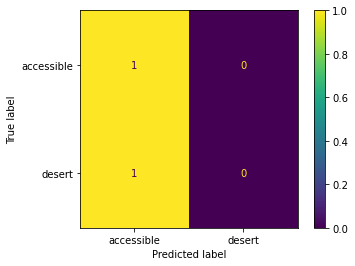

In [61]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize='true');

Our model did barely 0.01% better than the baseline. DC doesn't have quite enough census tracts to run a good model on. 

In [62]:
pipe.feature_names_in_

array(['bp', 'chd', 'chol', 'diab', 'obes', 'mhlth', 'tractwhite',
       'tractblack', 'tractasian', 'tractomultir', 'tracthispanic',
       'tractnhopi', 'tractaian'], dtype=object)

In [63]:
coef = pd.DataFrame(pipe.named_steps.lor.coef_, columns=pipe.feature_names_in_ ).T
coef = coef.sort_values(0)

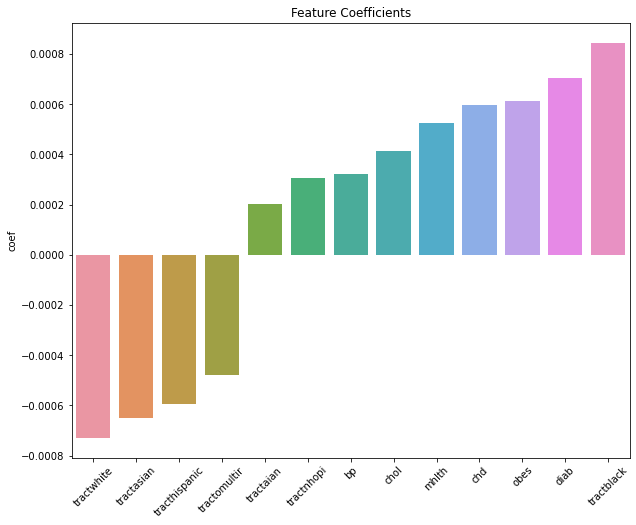

In [64]:
plt.figure(figsize=(10, 8))
sns.barplot(x=coef.index, y=coef[0])
plt.ylabel('coef')
plt.title('Feature Coefficients')
plt.xticks(rotation=45);
